In [1]:
using CSV
using DataFrames
using Random: MersenneTwister
using Plots
using StatsBase: mean

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


# Fig. 1

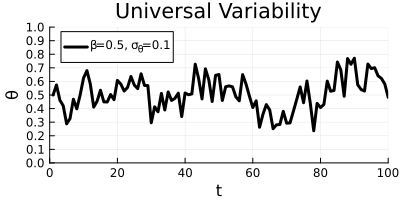

"/Users/inaba/Dropbox/workspace/Inaba2024/notebook/fig1.png"

In [3]:
function ar1(
    μ::Float64,         # expected average value
    β::Float64,         # 自己回帰の係数。|β| < 1 の場合に平均回帰性を持つ。μ = α / (1 - β)
    σ::Float64,         # std of white noise
    generations::Int,   # time steps
    rng::MersenneTwister
)::Vector{Float64}
    x = fill(μ, generations)
    alpha = μ * (1 - β)  # 定数項。μから逆算する。
    for t = 2:generations
        noise = σ * randn(rng)
        x_temp = alpha + β * x[t - 1] + noise
        x[t] = clamp(x_temp, 0.0, 1.0)
    end

    return x
end

μ = 0.5
t_max = 100
β, σ = (0.5, 0.1)
p = plot(
    ar1(μ, β, σ, t_max, MersenneTwister(2)),
    xlim=(0,100),
    ylim=(0,1),
    yticks=0:0.1:1,
    xlabel="t",
    ylabel="\\theta",
    title="Universal Variability",
    lw=3,
    lc=:black,
    label="\\beta=$(β), \\sigma_{\\theta}=$(σ)",
    size=(400, 200)
)
p |> display
savefig("img/fig1.png")

# Fig. 2

In [5]:
FILE_NAMES = [
    "../output/CircleModel_20240826_144719.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_182404.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_200917.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    # "../output/CircleModel_20240827_100534.csv",  # all, 10 trials
    "../output/CircleModel_20240827_170414.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_181750.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_215238.csv",  # all, 10 trials
];

In [6]:
dfs = [DataFrame(CSV.File(n)) for n in FILE_NAMES]
df = vcat(dfs...);

In [7]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:b, :resource_limit_β, :resource_limit_σ])
combination_var_df = groupby_combine_sort(combination_var_df, [:b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df)
@show size(combination_var_df);

size(regional_var_df) = (1650, 17)
size(universal_var_df) = (880, 17)
size(combination_var_df) = (750, 17)
size(regional_var_df) = (550, 3)
size(universal_var_df) = (440, 4)
size(combination_var_df) = (250, 5)


In [8]:
function plot_fig_regional(df::DataFrame)::Plots.Plot
    df.peak_node_variability = Float64.(df.peak_node_variability)
    replace!(df.peak_node_variability, 0 => 0.5)

    xticks = sort(unique(df.peak_node_variability))
    xticks_label = [x in [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 49.0] ? "$(Int(x))" : "" for x in xticks]
    xticks_label[1] = "0"

    p = plot(
        xticks=(xticks, xticks_label),
        xscale=:log2,
        xlim=(0.5, 49),
        yticks=0:0.1:1,
        ylim=(0, 1),
        xlabel="Prime Node Variability (\\sigma_{R})",
        ylabel="Average cooperation rate",
        title="Regional Variability",
        size=(450, 400),
    )

    for _df in groupby(df, [:b])
        plot!(_df.peak_node_variability, _df.cooperation_rate, label="b=$(_df.b[1])")
    end

    return p
end

function plot_fig_universal(df::DataFrame)::Plots.Plot
    σ_vec = sort(unique(df.resource_limit_σ))
    β_vec = sort(unique(df.resource_limit_β))
    p_vec = []

    for σ in σ_vec
        p = plot(
            xticks=β_vec,
            xlim=(minimum(β_vec), maximum(β_vec)),
            yticks=0:0.1:1.0,
            ylim=(0, 1.0),
            xlabel="Autoregressive coefficient (\\beta)",
            ylabel="Average cooperation rate",
            title="Universal Variability (\\sigma_{\\theta}=$(σ))",
        )
    
        for _df in groupby(df[df.resource_limit_σ .== σ, :], [:b])
            plot!(_df.resource_limit_β, _df.cooperation_rate, label="b=$(_df.b[1])")
        end

        push!(p_vec, p)
    end

    return plot(p_vec..., layout=(2, 2), size=(900, 800))
end;

In [9]:
function plot_fig_combination(df::DataFrame)::Plots.Plot
    b_vec = sort(unique(combination_var_df.b))
    σR_vec = sort(unique(combination_var_df.peak_node_variability))
    σθ_vec = sort(unique(combination_var_df.resource_limit_σ))
    β_vec = sort(unique(combination_var_df.resource_limit_β))
    p_vec = []

    for σθ in σθ_vec
        @show σθ
        for β in β_vec
            _df = combination_var_df[combination_var_df.resource_limit_σ .== σθ .&& combination_var_df.resource_limit_β .== β, :]
            p = plot(
                xticks=(1:length(σR_vec), σR_vec),
                xlim=(1, length(σR_vec)),
                # xscale=:log2,
                yticks=0:0.1:1.0,
                ylim=(0, 1.0),
                xlabel="",
                ylabel="",
                title="",
            )
            for __df in groupby(_df, [:b])
                plot!(__df.cooperation_rate, label=false)
            end
            push!(p_vec, p)
        end

        for σR in σR_vec
            _df = combination_var_df[combination_var_df.resource_limit_σ .== σθ .&& combination_var_df.peak_node_variability .== σR, :]
            p = plot(
                xticks=(1:length(β_vec), β_vec),
                xlim=(1, length(β_vec)),
                yticks=0:0.1:1.0,
                ylim=(0, 1.0),
                xlabel="",
                ylabel="",
                title="",
            )
            for __df in groupby(_df, [:b])
                plot!(__df.cooperation_rate, label=false)
            end
            push!(p_vec, p)
        end
    end

    return plot(p_vec..., layout=(4, 5), size=(900, 800), hspace=0.0)
end;

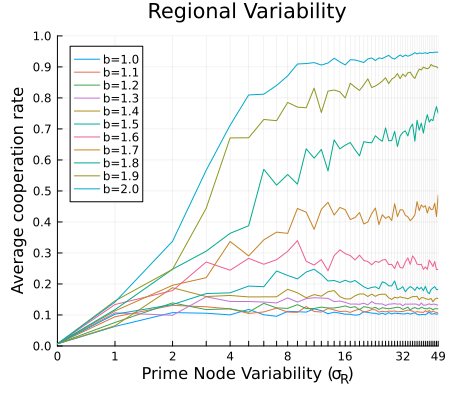

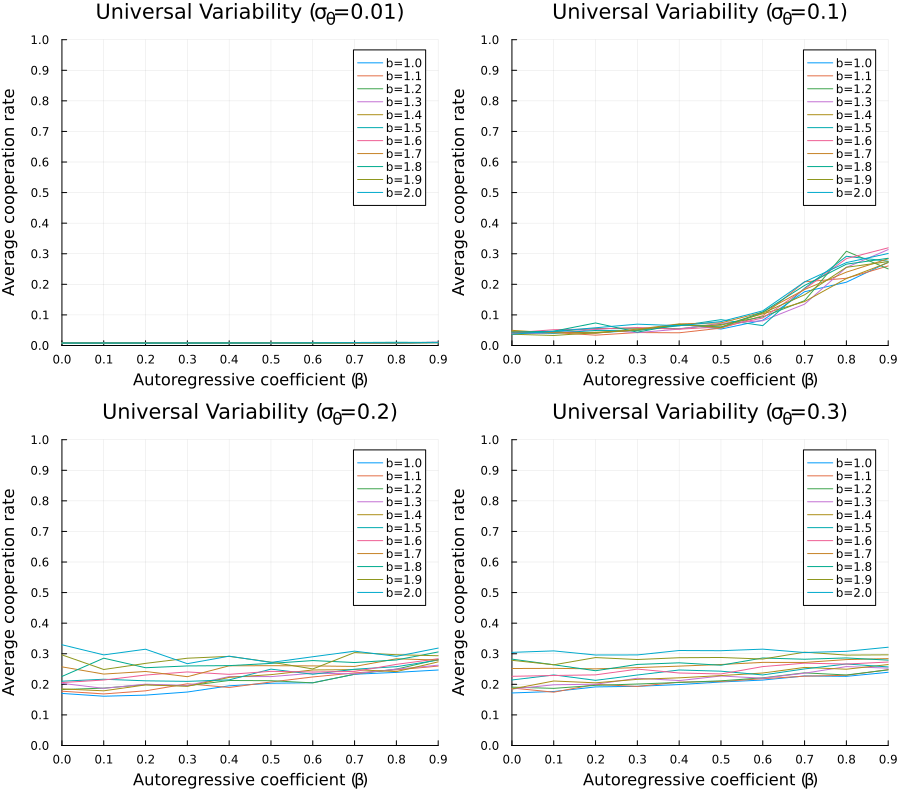

σθ = 0.1
σθ = 0.2


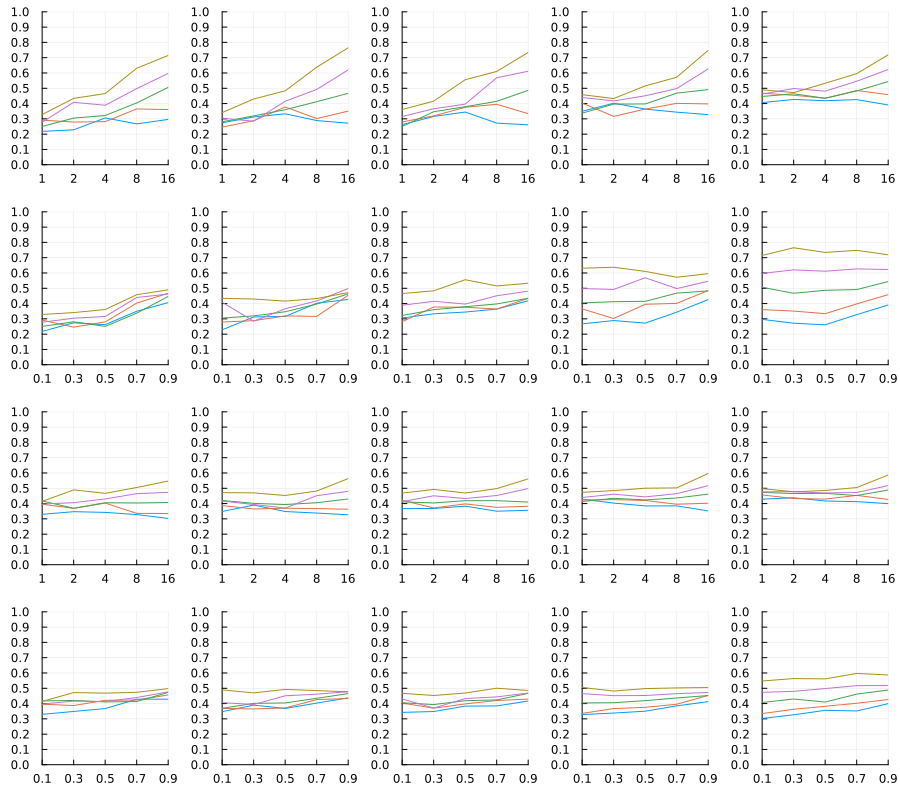

In [10]:
p = plot_fig_regional(regional_var_df)
p |> display
savefig("fig_regional.png")

p = plot_fig_universal(universal_var_df)
p |> display
savefig("fig_universal.png")

p = plot_fig_combination(combination_var_df)
p |> display
savefig("fig_combination.png");